In [1]:
# This notebook checks MNE functions for ECG and EOG detection
# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import configparser
import ancpbids
import plotly
import mpld3

from main_meg_qc import make_derivative_meg_qc, sanity_check, initial_stuff

from data_load_and_folders import load_meg_data, make_folders_meg, Epoch_meg
from RMSE_meq_qc import RMSE_meg_qc
from PSD_meg_qc import PSD_meg_qc
from Peaks_manual_meg_qc import PP_manual_meg_qc
from Peaks_auto_meg_qc import PP_auto_meg_qc
from ECG_meg_qc import ECG_meg_qc
from EOG_meg_qc import EOG_meg_qc
from universal_html_report import keep_fig_derivs, make_joined_report





Opening raw data file /Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds004107/sub-emptyroom/ses-19121026/meg/sub-emptyroom_ses-19121026_task-noise_meg.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 37380 ... 592739 =     20.849 ...   330.606 secs
Ready.
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
Stimulus channels detected: ['STI 001', 'STI 002', 'STI 003', 'STI 004', 'STI 005', 'STI 006', 'STI 014', 'STI 015', 'STI 016']
Removing projector <Projection | PCA-v1, active : False, n_channels : 102>
Removing projector <Projection | PCA-v2, active : False, n_channels : 102>
Removing projector <Projection | PCA-v3, active : False, n_channels : 102>
No events with set minimum duration were found using all sti

RMSE per epoch can not be calculated because no events are present. Check stimulus channel.


Magnetometers
  
Average absolute power per band:
delta 1.3241497072278024e-28
theta 6.655136800961098e-29
alpha 1.4213739128653629e-28
beta 8.922661344354433e-28
gamma 2.8259266624547775e-27
  
Average relative power per band:
delta 0.03071472199023287
theta 0.014645236494511917
alpha 0.031903224991133676
beta 0.19660945668657315
gamma 0.5994059356617438
  
Average power/freq per band:
delta 6.620748536139012e-29
theta 3.327568400480549e-29
alpha 7.106869564326814e-29
beta 8.922661344354433e-29
gamma 7.245965801166096e-29


Peak-to-Peak per epoch can not be calculated because no events are present. Check stimulus channel.
No ECG channels found is this data set, cardio artifacts can not be detected. ECG data can be reconstructed on base of magnetometers, but this will not be accurate and is not recommended.
Using EOG channels: EOG 061, EOG 062
EOG channel index for this subject is: [315 316]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 17929 samples (10.000 sec)

Now detecting blinks and generating corresponding events
F

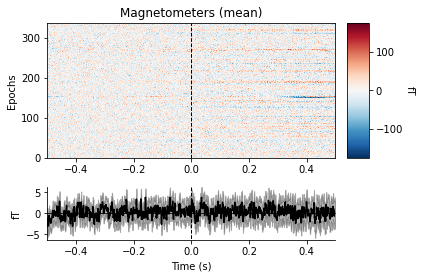

Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...


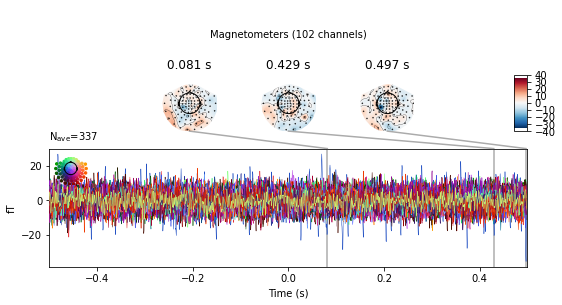

/Users/jenya/opt/anaconda3/envs/mne_new/lib/python3.9/site-packages/mpld3/mplexporter/exporter.py:84: UserWarning:

Blended transforms not yet supported. Zoom behavior may not work as expected.



In [2]:
#%% TRY TO SAVE DERIVATIVE FROM BIDS DATASET HERE:

config_file_name = 'settings.ini'
make_derivative_meg_qc(config_file_name)


In [ ]:
dict_of_dfs_epoch={'mags': None, 'grads': None}
if dict_of_dfs_epoch['mags'] is None and dict_of_dfs_epoch['grads'] is None:
    print('yes')



In [ ]:

from universal_plots import add_output_format
from universal_html_report import keep_fig_derivs

html_string='''<html>
            #     <head>
            #     <title>HTML File</title>
            #     </head>
            #     <body>
            #     <h1>stuff</h1>
            #     <p>Example stuff</p>
            #     </body>
            #     </html>'''
all_derivs=[(html_string, 'stuff_report', None, 'report')]
all_derivs += [(html_string, 'stuff_report2', None, 'plotly')]

for d in all_derivs:
    if d[3] == 'plotly': #or d[3] == 'matplotlib':
        print(d[3])

all_fig_derivs = keep_fig_derivs(all_derivs)

print(all_fig_derivs)

In [ ]:
# Other useful ancp stuff:

config = configparser.ConfigParser()
config.read('settings.ini')

default_direct = config['DEFAULT']['data_directory']
dataset_path = ancpbids.utils.fetch_dataset(default_direct)

from ancpbids import BIDSLayout
layout = BIDSLayout(dataset_path)

list_of_fifs = layout.get(suffix='meg', extension='.fif', return_type='filename')

list_of_subs = layout.get_subjects()


list_of_entities = layout.get_entities()
print(list_of_entities)

In [ ]:
#TRY SEPARATE FUNCS HERE

config = configparser.ConfigParser()
config.read('settings.ini')
data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003483/sub-009/ses-1/meg/sub-009_ses-1_task-deduction_run-1_meg.fif'
dict_of_dfs_epoch, epochs_mg, channels, raw_bandpass, raw_filtered_resampled, raw_cropped, raw = initial_stuff(config, data_file)
m_or_g_chosen = ['mags']
sid='009'
#dfs_ptp_amlitude_annot, bad_channels, amplit_annot_with_ch_names = PP_auto_meg_qc(sid, config, channels, raw, m_or_g_chosen)

#out_with_name_and_format = RMSE_meg_qc(sid, config, channels, dict_of_dfs_epoch, raw_filtered_resampled, m_or_g_chosen)

#out_with_name_and_format = PP_manual_meg_qc(sid, config, channels, dict_of_dfs_epoch, raw_filtered_resampled, m_or_g_chosen)

#out_with_name_and_format = PSD_meg_qc(sid, config, channels, raw_filtered_resampled, m_or_g_chosen)

#out_with_name_and_format = ECG_meg_qc(config, raw, m_or_g_chosen)

out_with_name_and_format = EOG_meg_qc(config, raw, m_or_g_chosen)

#out_with_name_and_format, bad_channels = PP_auto_meg_qc(sid, config, channels, raw_filtered_resampled, m_or_g_chosen)

# psd_section = config['PSD']
# freq_min = psd_section.getfloat('freq_min') 
# freq_max = psd_section.getfloat('freq_max') 
# mean_power_per_band_needed = psd_section.getboolean('mean_power_per_band_needed')
# n_fft = psd_section.getint('n_fft')
# n_per_seg = psd_section.getint('n_per_seg')

# m_or_g='mags'
# fig, fig_desc, fig_path, dfs_with_name = Power_of_freq_meg(ch_names=channels[m_or_g], m_or_g = m_or_g, freqs = freqs[m_or_g], psds = psds[m_or_g], mean_power_per_band_needed = mean_power_per_band_needed, plotflag = True, sid = sid)

#deriv_with_name_and_format = PSD_meg_qc(sid, config, channels, raw_filtered_resampled, m_or_g_chosen)


#figs = ECG_meg_qc(config, raw, m_or_g_chosen)

print(out_with_name_and_format)

In [ ]:
# out_with_name_and_format[0].convert_fig_to_html()
from universal_plots import QC_derivative
dr = QC_derivative('001', 'mean_EC_epoch', None, '')
# dr_html = dr.convert_fig_to_html()
# l=["a"]

# if dr_html is not None:

#     l += dr_html
    
# print(l)

sec = dr.get_section()
print(sec)


In [ ]:
print(figs)
all_fig_derivs = figs
figures_report = {}
for x in range(0, len(all_fig_derivs)):
    if all_fig_derivs[x][3]=='plotly':
        figures_report["f{0}".format(x)] = plotly.io.to_html(all_fig_derivs[x][0])
    elif all_fig_derivs[x][3]=='matplotlib':
        figures_report["f{0}".format(x)] = mpld3.fig_to_html(all_fig_derivs[x][0]);

print(figures_report)

In [ ]:

import mpld3

html_fig=mpld3.fig_to_html(figs[0][0])
print(html_fig)



# file = open('matpl_fig.html', "w")
# file.write(html_fig)
# file.close()

In [ ]:
html_string = '''
<!doctype html>
<html>
    <head>
        <meta charset="UTF-8">
        <title>MEG QC: Frequency spectrum Report</title>
        <style>body{ margin:0 100;}</style>
    </head>
    
    <body style="font-family: Arial">
        <center>
        <h1>MEG data quality analysis report</h1>
        <br></br>
        <!-- *** Section 1 *** --->
        <h2>Frequency spectrum per channel</h2>
        ''' + html_fig + '''
        <p>graph description...</p>
        </center>
    
    </body>
</html>'''

with open('report_trial.html', 'w', encoding = 'utf8') as f:
    f.write(html_string)

In [ ]:
#config = configparser.ConfigParser()
#config.read('settings.ini')

#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds000117/sub-01/ses-meg/meg/sub-01_ses-meg_task-facerecognition_run-01_meg.fif'
# file does not start with a file id tag

#data_file = '/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003392/sub-01/meg/sub-01_task-localizer_meg.fif'
# SSS frilter. need to allow maxshiled.

#data_file ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003694/sub-01/meg/sub-01_task-MEM_run-01_meg.fif'
#raw = mne.io.read_raw_fif(data_file, on_split_missing='ignore')


#dict_of_dfs_epoch, epochs_mg, channels, raw_bandpass, raw_filtered_resampled, raw_cropped, raw = initial_stuff(config, data_file)

#data_file ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds003922/sub-Mp150285/ses-01/meg/sub-Mp150285_ses-01_acq-crosstalk_meg.fif'
#Could not find measurement data: how many in this set, which subjects?


data_file ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/ds004229/sub-102/meg/sub-102_task-amnoise_meg.fif'
#SSS filter
raw = mne.io.read_raw_fif(data_file, allow_maxshield=True)


#data_dir ='/Volumes/M2_DATA/MEG_QC_stuff/data/from openneuro/not fitting no fif/ds000246/sub-0001/meg/sub-0001_task-AEF_run-01_meg.ds'
#raw = mne.io.read_raw_ctf(data_dir)


In [ ]:
raw
# reference channels for ctf systems already implemented (subtracted), is this done automatically by the ctf systems?

In [ ]:
import configparser
from ancpbids import BIDSLayout

config = configparser.ConfigParser()
config.read('settings.ini')

default_section = config['DEFAULT']

m_or_g_chosen = default_section['do_for'] 
m_or_g_chosen = m_or_g_chosen.replace(" ", "")
m_or_g_chosen = m_or_g_chosen.split(",")
#m_or_g_chosen = select_m_or_g(default_section)

dataset_path = default_section['data_directory']

layout = BIDSLayout(dataset_path)
schema = layout.schema

#create derivative folder first!
derivative = layout.dataset.create_derivative(name="Meg_QC")
derivative.dataset_description.GeneratedBy.Name = "MEG QC Pipeline"

list_of_subs = layout.get_subjects()
#print(list_of_subs)
for sub in list_of_subs:
    list_of_fifs_per_sub = layout.get(suffix='meg', extension='.fif', sub=sub)
    for_entities={}
    for file in list_of_fifs_per_sub:
        k=file['entities'][1]['key']
        v=file['entities'][1]['value']
        for_entities[k]=v
    print(for_entities)

#print(list_of_fifs_per_sub)
# for sid in [list_of_subs[0]]: #RUN OVER JUST 1 SUBJ
# #for sid in list_of_subs: 

#     subject_folder = derivative.create_folder(type_=schema.Subject, name='sub-'+sid)

#     list_of_fifs = layout.get(suffix='meg', extension='.fif', return_type='filename', subj=sid)
#     #Devide here fifs by task, ses , run

#     for data_file in [list_of_fifs[0]]: #RUN OVER JUST 1 FIF because is not divided by tasks yet..
#         print(type(data_file))